In [ ]:
pip install -q git+https://github.com/cpgoodri/jax_transformations3d.git

In [8]:
%load_ext autoreload
%autoreload 2

import jax
from jax import jit, vmap
from functools import partial
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax_transformations3d as jts
import colorsys
import numpy as np
import math
import time
from tqdm.auto import tqdm, trange

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
@partial(vmap, in_axes=(None, None, 0, 0), out_axes=-1)
def ray_intersect(ray_origin, ray_dir, sphere_center, sphere_radius):
    # ray_dir should be normalized
    offset_ray_origin = ray_origin - sphere_center
    a = jnp.dot(ray_dir, ray_dir)
    b = 2 * jnp.dot(offset_ray_origin, ray_dir)
    c = jnp.dot(offset_ray_origin, offset_ray_origin) - sphere_radius**2

    discriminant = b**2 - 4 * a * c
    dist = (-b - jnp.sqrt(discriminant)) / (2 * a)

    # sphere was hit if (discriminant >= 0) & (dist >= 0)
    # if discriminant < 0, then dist is nan already, if dist < 0, 
    # meaning hitpoint is against ray direction, set dist to nan
    dist = jnp.where(dist < 0, jnp.nan, dist)

    return dist

def ray_intersect_target_batch(ray_origin, ray_dir, sphere_center, sphere_radius):
    dist = ray_intersect(ray_origin, ray_dir, sphere_center, sphere_radius)
    closest_hit = jnp.nanargmin(dist)
    dist = dist[closest_hit]

    return dist, closest_hit

In [72]:
jax.lax.fori_loop(0, 6, lambda i, x: (x[0]+1, x[1]), (1.1123, 2))

(DeviceArray(7.1123, dtype=float32, weak_type=True),
 DeviceArray(2, dtype=int32, weak_type=True))

In [56]:
def ray_trace_single_hit(
    ray_origin,
    ray_dir,
    key,
    sphere_center,
    sphere_radius,
    mat_color,
    em_color,
    em_strength,
    mat
):
    pass
    


@jit
@partial(vmap, in_axes=(1, 1, 1, None, None, None, None, None, None))
@partial(vmap, in_axes=(0, 0, 0, None, None, None, None, None, None))
def full_ray_trace(
    ray_origin,
    ray_dir,
    key,
    sphere_center,
    sphere_radius,
    mat_color,
    em_color,
    em_strength,
    mat,
):
    inc_light = jnp.zeros((3,))
    ray_color = jnp.ones((3,))
    
    jax.lax.fori_loop(0, 6, body_fun, init_val)

    for i in range(8):
        dist, closest_hit = ray_intersect_target_batch(
            ray_origin, ray_dir, sphere_center, sphere_radius
        )

        did_hit = ~jnp.isnan(dist)  # or: closest_hit != -1

        # done = done | (did_hit & (em_strength[closest_hit] == 1) & (jnp.arange(10)[i] == 0))
        # did_hit = did_hit & ~done

        hit_point = ray_origin + ray_dir * dist
        normal = hit_point - sphere_center[closest_hit]
        normal = normal / jnp.linalg.norm(normal)

        emitted_light = em_color[closest_hit] * em_strength[closest_hit]
        light_strength = jnp.dot(normal, -ray_dir)
        light_strength = jnp.where(jnp.isnan(light_strength), 0, light_strength)
        inc_light += did_hit * (emitted_light * ray_color)
        # *light_strength
        ray_color = (
            did_hit * ray_color * mat_color[closest_hit] + (~did_hit) * ray_color
        )

        key, subkey = jax.random.split(key, 2)
        random_dir = jax.random.normal(subkey, (3,))
        random_dir = random_dir / jnp.linalg.norm(random_dir)
        diffuse_reflect = random_dir * jnp.sign(jnp.dot(random_dir, normal))
        diffuse_reflect = diffuse_reflect / jnp.linalg.norm(diffuse_reflect)

        specular_reflect = (
            ray_dir - 2 * jnp.dot(ray_dir, normal) * normal
        )  # maybe should be -raydir too?
        specular_reflect = specular_reflect / jnp.linalg.norm(specular_reflect)

        alpha = mat[closest_hit]
        reflect_dir = alpha * diffuse_reflect + (1 - alpha) * specular_reflect

        ray_origin = hit_point
        ray_dir = reflect_dir

    return inc_light

31.093120574951172


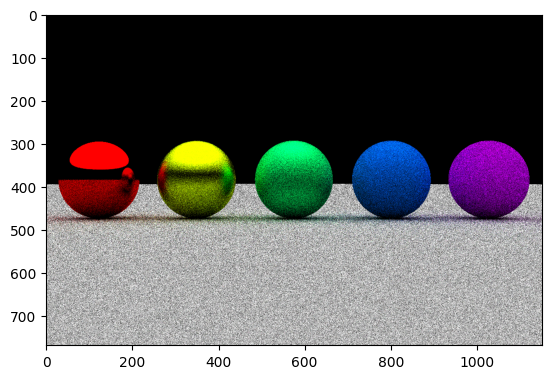

In [60]:
# bounce count, time
# 4, 31
# 8, 61.3
# 16, 121-122

sphere_pos, sphere_radius, mat_color, em_color, em_strength, mat = stack_dict_list(spheres)

key = jax.random.PRNGKey(0)
result_img = jnp.zeros((res_y, res_x, 3))

# this should be before every ray trace, but for now keep it here
x_offset, y_offset = (jax.random.uniform(subkey, (2,)) - 0.5) * 0.005
ray_pos, ray_dirs = get_init(res_x, res_y, x_persp, y_persp, camera_persp, x_offset, y_offset)
#

result_img.block_until_ready()
t0 = time.time()

k = 10
for i in range(k):
    key, subkey = jax.random.split(key, 2)
    key_grid = jax.random.split(subkey, res_x * res_y).reshape((res_x, res_y, -1))

    
    result_img += full_ray_trace(
        ray_pos,
        ray_dirs,
        key_grid,
        sphere_pos,
        sphere_radius,
        mat_color,
        em_color,
        em_strength,
        mat,
    )

result_img.block_until_ready()
print((time.time()-t0)*1000)

plt.imshow(result_img/jnp.quantile(result_img.flatten(), 0.95))
plt.show()

In [4]:
base_res = 256
x_persp, y_persp = 1.5 * 3, 1 * 3
res_x, res_y = int(base_res * x_persp), int(base_res * y_persp)
camera_persp = 12



n = 5
spheres = [
    {
        "pos": [5, -5 + l * 10, 0],
        "radius": 1,
        "mat_color": colorsys.hls_to_rgb(l * (1 - 1 / n), 0.5, 1),
        "em_color": colorsys.hls_to_rgb(l * (1 - 1 / n), 0.5, 1),
        "em_strength": 0,
        "mat": max(l, 0.01),
    }
    for l in jnp.linspace(0, 1, n)
] + [
    # {'pos': [10000+15, 0, 0], 'radius': 10000, 'mat_color': [1, 1, 1], 'em_color': [1, 1, 1], 'em_strength': 0.01, 'mat': 0.5},
    # ground
    {
        "pos": [5, 0, 40000],
        "radius": 40000 - 1,
        "mat_color": [1, 1, 1],
        "em_color": [1, 1, 1],
        "em_strength": 0,
        "mat": 1,
    },
    # back wall
    # {'pos': [40000, 0, 0], 'radius': 40000-100, 'mat_color': [0.1, .1, 0.1], 'em_color': [1, 1, 1], 'em_strength': 0, 'mat': 1},
    # ceiling light
    {
        "pos": [5, 0, -40000],
        "radius": 40000 - 5000,
        "mat_color": [1, 1, 1],
        "em_color": [1, 1, 1],
        "em_strength": 0.000001,
        "mat": 1,
    },
    # {'pos': [10, 5, -5], 'radius': 4, 'mat_color': [1, 1, 1], 'em_color': [1, 1, 1], 'em_strength': 0, 'mat': 0},
    # {'pos': [5-math.sin(math.pi*i*2)*10, math.cos(math.pi*i*2)*10, -4], 'radius': 1, 'mat_color': [0, 0, 0], 'em_color': [1, 1, 1], 'em_strength': 3, 'mat': 1},
    # {'pos': [6, -10, 0], 'radius': 0.5, 'mat_color': [0, 0, 0], 'em_color': [0, 0.5, 1], 'em_strength': 40, 'mat': 1},
]